In [76]:
### going to import household data and train a classifier on the data that takes as input the datetime information and outputs a daily load profile

import pandas as pd
import numpy as np
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import holidays
import datetime

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import RandomizedSearchCV




In [77]:
# write a function to create datetime features from the datetime index of the input dataframe
def create_datetime_features(df):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    return df

def create_holiday_features(df, df_holidays, df_holiday_periods=None):

    df_1 = days_until_next_holiday_encoder(df, df_holidays)

    df_2 = days_since_last_holiday_encoder(df, df_holidays)

    df_3 = pd.concat([df_1, df_2], axis=1)

    if df_holiday_periods is not None:
        df_3 = pd.concat([df_3, df_holiday_periods], axis=1)

    df_3 = df_3.loc[~df_3.index.duplicated(keep='first')]

    df_3 = df_3.reindex(df.index, fill_value=0)

    return df_3


def days_until_next_holiday_encoder(df, df_holidays):

    df_concat = pd.concat([df, df_holidays], axis=1)
    df_concat["days_until_next_holiday"] = 0
    for ind in df_concat.index:
        try:
            next_holiday = df_concat["holiday_dummy"].loc[ind:].first_valid_index()
            days_until_next_holiday = (next_holiday - ind).days
            df_concat.loc[ind, "days_until_next_holiday"] = days_until_next_holiday
        except:
            pass

    return df_concat[["days_until_next_holiday"]]


def days_since_last_holiday_encoder(df, df_holidays):

    df_concat = pd.concat([df, df_holidays], axis=1)
    df_concat["days_since_last_holiday"] = 0
    for ind in df_concat.index:
        next_holiday = df_concat["holiday_dummy"].loc[:ind].last_valid_index()
        days_since_last_holiday = (ind - next_holiday).days
        df_concat.loc[ind, "days_since_last_holiday"] = days_since_last_holiday

    return df_concat[["days_since_last_holiday"]]


def get_year_list(df):
    'Return the list of years in the historic data'
    years = df.index.year.unique()
    years = years.sort_values()
    return list(years)


def get_holidays(years, shortcut):

    country = getattr(holidays, shortcut)
    holidays_dict = country(years=years)
    df_holidays = pd.DataFrame(holidays_dict.values(), index=holidays_dict.keys())
    df_holidays[0] = 1
    df_holidays_dummies = df_holidays
    df_holidays_dummies.columns = ["holiday_dummy"]
    df_holidays_dummies.index = pd.DatetimeIndex(df_holidays.index)
    df_holidays_dummies = df_holidays_dummies.sort_index()

    return df_holidays_dummies


def timeseries_dataframe_pivot(df):
    df['date'] = df.index.date
    df['time'] = df.index.time

    df_pivot = df.pivot(index='date', columns='time')

    n_days, n_timesteps = df_pivot.shape

    df_pivot.dropna(thresh = n_timesteps // 5, inplace=True)

    df_pivot = df_pivot.fillna(method='ffill', axis = 0)

    df_pivot = df_pivot.droplevel(0, axis=1)

    df_pivot.columns.name = None

    df_pivot.index = pd.DatetimeIndex(df_pivot.index)

    return df_pivot


In [60]:
df = pd.read_csv(r'data\cleaned_data\5_household\power\SFH4_demand_W.csv', index_col=0, parse_dates=True)


df = timeseries_dataframe_pivot(df).dropna()



In [61]:


years = get_year_list(df)
df_holidays_dummies = get_holidays(years, "DE")
df_holidays = create_holiday_features(df, df_holidays_dummies)

In [62]:

df = create_datetime_features(df)

df = pd.concat([df, df_holidays], axis=1)

df = df.astype('float32')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2018-05-16 to 2019-12-31
Columns: 103 entries, 00:00:00 to days_since_last_holiday
dtypes: float64(96), int32(1), int64(6)
memory usage: 497.3 KB


In [126]:
# split the data into train and test

train, test = train_test_split(df, test_size=0.2, shuffle=False)

train = train.values
test = test.values



# scale the data

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#features and target

X_train = train_scaled[:,96:]
y_train = train_scaled[:,:96]

X_test = test_scaled[:,96:]
y_test = test_scaled[:,:96]


param_distributions = {'n_estimators': np.arange(100, 2000, 100),
                       'max_depth': [9, 12, 18, 24],
                       'learning_rate': [0.001, 0.01],
                       'subsample': [0.5, 0.7, 0.9],
                       'colsample_bytree': [0.5, 0.7, 0.9],
                       'reg_alpha': [0, 0.1, 1, 10],
                       'reg_lambda': [0, 0.1, 1, 10]}

# define the model

model = XGBRegressor(objective='reg:pseudohubererror')


In [127]:

# define the search
search = RandomizedSearchCV(model, param_distributions, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3, random_state=42)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [128]:
predictions = model.predict(X_test)

In [129]:
df_compare = pd.DataFrame({'gt': y_test.reshape(-1,1).flatten(), 'predictions': predictions.reshape(-1,1).flatten()})

px.line(df_compare, x=df_compare.index, y=['gt', 'predictions'], title='XGBoost Regression')

In [113]:
# save predictions

df_compare.to_csv('XGBoost_predictions_huberloss.csv')

In [ ]:
# T

<Axes: title={'center': 'XGBoost Regression'}>

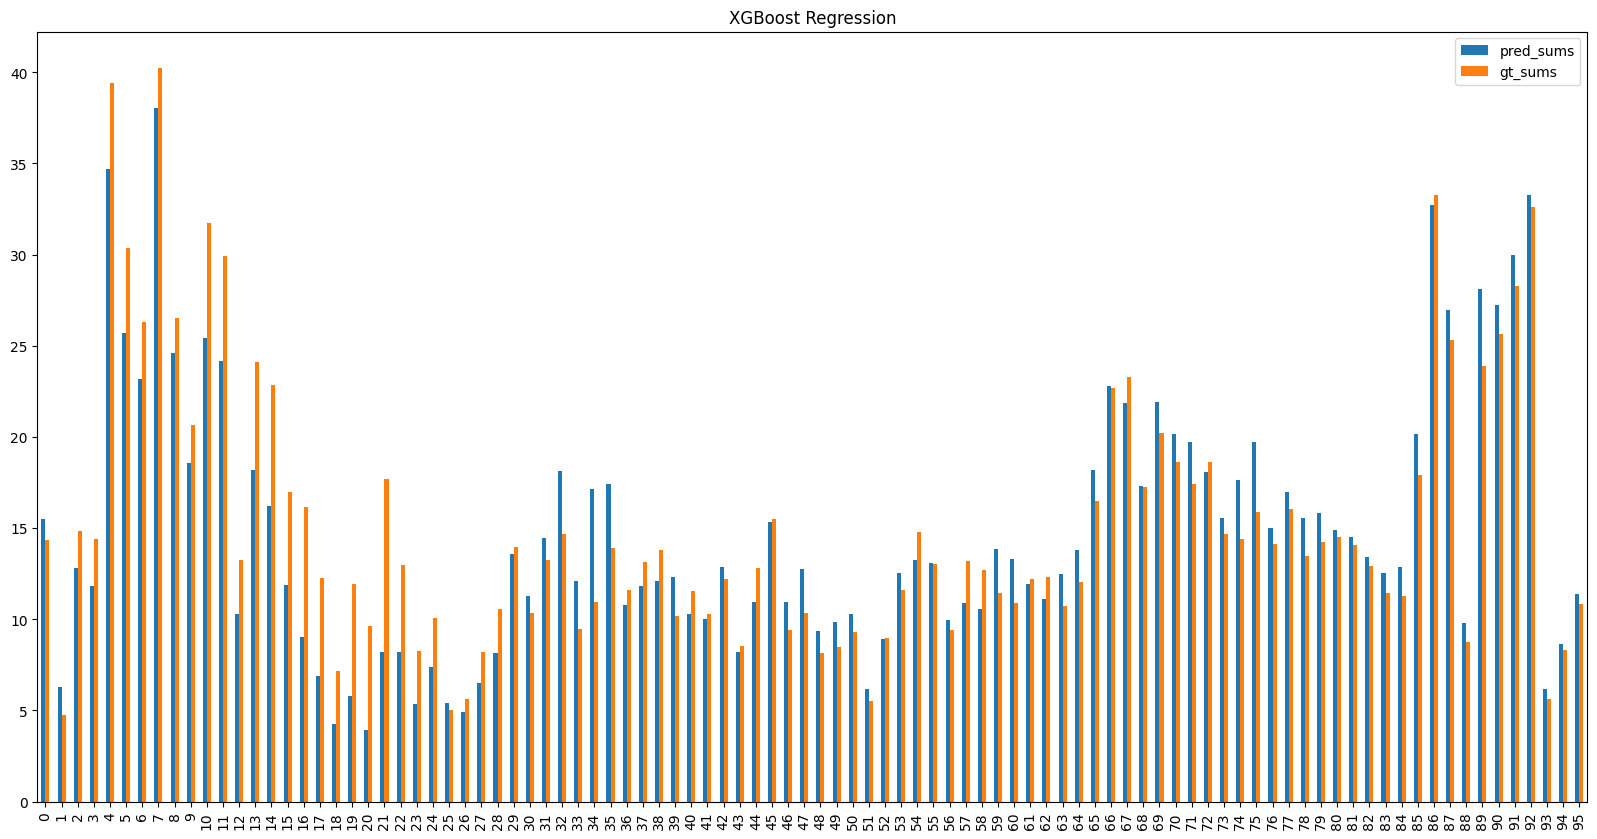

In [130]:
pd.DataFrame({'pred_sums': predictions.sum(axis=0), 'gt_sums': y_test.sum(axis=0)}).plot(kind='bar', title='XGBoost Regression', figsize=(20,10))